# Personal Loan Prediction using ANN-EA Hybrid Systems

## Introduction

The dataset contains data on 5000 customers including demographic information, the customer's relationship with the bank and the customer response to the last personal loan campaign.

The **GOAL** is to predict the likelihood of a liability customer buying personal loans.

This prediction task will be done using Neural Networks and the optimization of weights, instead of being done by back-propagation (gradient descent method), will be done using:
- Genetic Algorithm
- Cultural Algorithm
- Particle Swarm Optimization
- Ant Colony Optimization

## Data Preprocessing

### Imports

In [1]:
import random
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

### Reading the Data

In [2]:
data = pd.read_csv(r'dataset/personal_loan.csv')

In [3]:
X = data.drop(['Personal Loan', 'ID', 'ZIP Code'], axis=1)
y = data['Personal Loan'].values

### Oversampling

In [4]:
smote = SMOTE()
X, y = smote.fit_resample(X, y)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [6]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

## Artificial Neural Networks

In [7]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

def reLU(z):
    return np.maximum(0.0, z)


class NeuralNetwork:
    def __init__(self, layer_size, weights):
        self.input_size = layer_size[0]
        self.hidden1_size = layer_size[1]
        self.output_size = layer_size[2]

        self.weights = weights

        self.W1_size = self.input_size * self.hidden1_size
        self.W2_size = self.hidden1_size * self.output_size

        self.w1 = self.weights[:self.W1_size].reshape(self.input_size, self.hidden1_size)
        self.w2 = self.weights[self.W1_size: self.W1_size + self.W2_size].reshape(self.hidden1_size, self.output_size)

        self.biases = self.weights[self.W1_size + self.W2_size:]

        self.b1 = self.biases[:self.hidden1_size]
        self.b2 = self.biases[self.hidden1_size:self.hidden1_size + self.output_size]

    def forwardPropagation(self, X):
        self.z2 = np.dot(X, self.w1) + self.b1
        self.a2 = reLU(self.z2)

        self.z3 = np.dot(self.a2, self.w2) + self.b2
        output = sigmoid(self.z3)

        return output

In [8]:
layer_size = [11, 8, 1]
tot_weights = layer_size[0] * layer_size[1] + \
              layer_size[1] * layer_size[2]
tot_biases = layer_size[1] + layer_size[2]

tot_length = tot_biases + tot_weights

In [9]:
def fitness(weight):
    nn = NeuralNetwork(layer_size, weight)
    y_pred = nn.forwardPropagation(x_train)
    return metrics.accuracy_score(np.round(y_pred), y_train)

## Genetic Algorithm

In [10]:
population = 500
epochs = 20
pool_size = 20

In [20]:
def init_population():
    weight_pop = []
    for _ in range(population):
        weight_pop.append(np.random.uniform(-2, 2, tot_length))

    return np.array(weight_pop)

np.random.seed(7)
initial_population = init_population()

In [21]:
def random_selection(population):
    mating_pool = population[:pool_size]
    return mating_pool

def crossover(mating_pool):
    children = []

    while len(mating_pool):
        p1_index, p2_index = np.random.choice(mating_pool.shape[0], 2, replace=False)
        p1, p2 = mating_pool[p1_index, :], mating_pool[p2_index, :]
        r = random.uniform(0, 1)
        s = random.uniform(-1, 0)
        c1 = r * p1 + s * p2
        c2 = s * p2 + r * p1
        children.extend([c1, c2])
        mating_pool = np.delete(mating_pool, [p1_index, p2_index], axis=0)
    return np.array(children)

def mutation(children):
    mut_mat = np.random.uniform(0.75, 1.25, children.shape)
    children = mut_mat * children
    return children

def replace_population(child_population, current_population):
    next_population = np.append(current_population[:population - pool_size], child_population, axis=0)
    next_population = np.array(sorted(next_population, key=lambda x: fitness(x), reverse=True))
    return next_population

In [23]:
final = 0
fit_plt = []
current_population = np.array(sorted(initial_population, key=lambda x: fitness(x), reverse=True))
for i in range(epochs):
    mating_pool = random_selection(current_population)
    children = crossover(mating_pool)
    children = mutation(children)
    current_population = replace_population(children, current_population)
    final = current_population[0]
    final_fit = fitness(final)
    print(f"Best fitness of Generation {i + 1}: {final_fit}")
    fit_plt.append(final_fit)

Best fitness of Generation 1: 0.7733683628318584
Best fitness of Generation 2: 0.7874723451327433
Best fitness of Generation 3: 0.8084900442477876
Best fitness of Generation 4: 0.8319966814159292
Best fitness of Generation 5: 0.8319966814159292
Best fitness of Generation 6: 0.8555033185840708
Best fitness of Generation 7: 0.8680862831858407
Best fitness of Generation 8: 0.8680862831858407
Best fitness of Generation 9: 0.8680862831858407
Best fitness of Generation 10: 0.8680862831858407
Best fitness of Generation 11: 0.8733407079646017
Best fitness of Generation 12: 0.8733407079646017
Best fitness of Generation 13: 0.8733407079646017
Best fitness of Generation 14: 0.8733407079646017
Best fitness of Generation 15: 0.8733407079646017
Best fitness of Generation 16: 0.8733407079646017
Best fitness of Generation 17: 0.8769358407079646
Best fitness of Generation 18: 0.8769358407079646
Best fitness of Generation 19: 0.8769358407079646
Best fitness of Generation 20: 0.8769358407079646


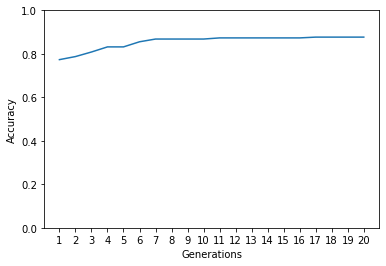

In [24]:
import matplotlib.pyplot as plt
plt.xlabel("Generations")
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.xticks(np.arange(1, epochs + 1))
plt.plot(np.arange(1,epochs + 1), fit_plt)
plt.show()

In [26]:
nn = NeuralNetwork(layer_size, final)
out = nn.forwardPropagation(x_test)
print(metrics.classification_report(np.round(out), y_test))

              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86       771
         1.0       0.94      0.84      0.89      1037

    accuracy                           0.88      1808
   macro avg       0.87      0.88      0.87      1808
weighted avg       0.88      0.88      0.88      1808

[[712  59]
 [167 870]]


## Cultural Algorithm

In [27]:
def acceptance(current_population):
    belief_space = []
    for i in current_population:
        if np.abs(np.mean(i)) < 0.4:
            belief_space.append(i)
    belief_space = np.array(belief_space)
    belief_child = crossover(belief_space)
    belief_space = replace_population(belief_child, belief_space)

    return belief_space

fit_plt_ca = []
final = 0
current_population = np.array(sorted(initial_population, key=lambda x: fitness(x), reverse=True))
belief_space = acceptance(current_population)
for i in range(epochs):
    mating_pool = random_selection(current_population)

    children = crossover(mating_pool)
    children = mutation(children)
    current_population = replace_population(children, current_population)

    belief_space = acceptance(current_population)
    current_population = replace_population(belief_space, current_population)

    final_ca = current_population[0]
    final_fit_ca = fitness(final_ca)
    print(f"Best fitness of Generation {i + 1}: {final_fit_ca}")
    fit_plt_ca.append(final_fit_ca)

Best fitness of Generation 1: 0.8091814159292036
Best fitness of Generation 2: 0.8324115044247787
Best fitness of Generation 3: 0.8429203539823009
Best fitness of Generation 4: 0.8429203539823009
Best fitness of Generation 5: 0.8454092920353983
Best fitness of Generation 6: 0.8513550884955752
Best fitness of Generation 7: 0.8545353982300885
Best fitness of Generation 8: 0.8662887168141593
Best fitness of Generation 9: 0.8709900442477876
Best fitness of Generation 10: 0.8783185840707964
Best fitness of Generation 11: 0.8790099557522124
Best fitness of Generation 12: 0.8920077433628318
Best fitness of Generation 13: 0.8936670353982301
Best fitness of Generation 14: 0.8936670353982301
Best fitness of Generation 15: 0.8936670353982301
Best fitness of Generation 16: 0.8975387168141593
Best fitness of Generation 17: 0.8975387168141593
Best fitness of Generation 18: 0.8975387168141593
Best fitness of Generation 19: 0.8975387168141593
Best fitness of Generation 20: 0.8975387168141593


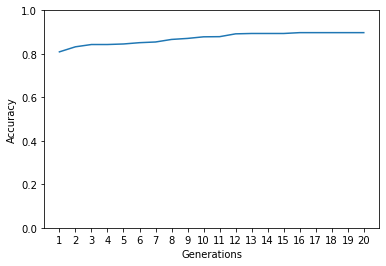

In [28]:
import matplotlib.pyplot as plt
plt.xlabel("Generations")
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.xticks(np.arange(1, epochs + 1))
plt.plot(np.arange(1,epochs + 1), fit_plt_ca)
plt.show()

In [29]:
nn = NeuralNetwork(layer_size, final_ca)
out = nn.forwardPropagation(x_test)
print(metrics.classification_report(np.round(out), y_test))

              precision    recall  f1-score   support

         0.0       0.87      0.91      0.89       840
         1.0       0.92      0.88      0.90       968

    accuracy                           0.90      1808
   macro avg       0.90      0.90      0.90      1808
weighted avg       0.90      0.90      0.90      1808



## Particle Swarm Optimization

In [30]:
generation = 20
w = 0.5
c1 = -1
c2 = 2

fit_plt_pso = []
def pso():
    particles = initial_population
    velocities = np.zeros((population, tot_length))

    pbest_pos = np.copy(particles)
    pbest_fit = np.array([fitness(particle) for particle in particles])

    gbest_pos = pbest_pos[np.argmax(pbest_fit)]
    gbest_fit = np.max(pbest_fit)

    for i in range(generation):
        r1 = np.random.uniform(0, 1, (population, tot_length))
        r2 = np.random.uniform(0, 1, (population, tot_length))

        velocities = (w * velocities) + c1 * r1 * (pbest_pos - particles) + c2 * r2 * (gbest_pos - particles)

        particles += velocities

        particles_fit = np.array([fitness(particle) for particle in particles])

        improved_indices = np.where(particles_fit < pbest_fit)
        pbest_pos[improved_indices] = particles[improved_indices]
        pbest_fit[improved_indices] = particles_fit[improved_indices]

        if np.max(particles_fit) > gbest_fit:
            gbest_pos = particles[np.argmax(particles_fit)]
            gbest_fit = np.max(particles_fit)
        print(f"Best fitness of Generation {i + 1}: {gbest_fit}")
        fit_plt_pso.append(gbest_fit)
    return gbest_pos, gbest_fit

In [31]:
pso_weight, pso_fitness = pso()

Best fitness of Generation 1: 0.8231471238938053
Best fitness of Generation 2: 0.8732024336283186
Best fitness of Generation 3: 0.8879977876106194
Best fitness of Generation 4: 0.8942201327433629
Best fitness of Generation 5: 0.9007190265486725
Best fitness of Generation 6: 0.9040376106194691
Best fitness of Generation 7: 0.9047289823008849
Best fitness of Generation 8: 0.9081858407079646
Best fitness of Generation 9: 0.9112278761061947
Best fitness of Generation 10: 0.9137168141592921
Best fitness of Generation 11: 0.9184181415929203
Best fitness of Generation 12: 0.9204922566371682
Best fitness of Generation 13: 0.9236725663716814
Best fitness of Generation 14: 0.9268528761061947
Best fitness of Generation 15: 0.9290652654867256
Best fitness of Generation 16: 0.9304480088495575
Best fitness of Generation 17: 0.9304480088495575
Best fitness of Generation 18: 0.9304480088495575
Best fitness of Generation 19: 0.9311393805309734
Best fitness of Generation 20: 0.9325221238938053


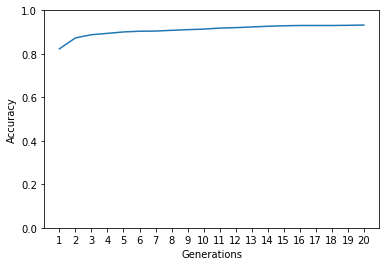

In [32]:
import matplotlib.pyplot as plt
plt.xlabel("Generations")
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.xticks(np.arange(1, epochs + 1))
plt.plot(np.arange(1,epochs + 1), fit_plt_pso)
plt.show()

In [33]:
nn = NeuralNetwork(layer_size, pso_weight)
out = nn.forwardPropagation(x_test)
print(metrics.classification_report(np.round(out), y_test))

              precision    recall  f1-score   support

         0.0       0.92      0.93      0.93       863
         1.0       0.94      0.92      0.93       945

    accuracy                           0.93      1808
   macro avg       0.93      0.93      0.93      1808
weighted avg       0.93      0.93      0.93      1808



## Ant Colony Optimization

In [34]:
ns = na = 100
nd = tot_length
ng = 20

lb = np.full(nd, -10)
ub = np.full(nd, 10)

ants = initial_population[:na]
x_aco = initial_population[0]
rho = 0.05
dec = 0.8
inc = 0.4
delta = 0.2

def aco(xbest):
    h = (ub - lb) / ns
    T = np.ones((ns, nd))

    xb = xbest
    nb = np.random.randint(0, ns, nd)
    for ant in ants:
        n = np.random.randint(0, ns, nd)
        x = lb + n * h
        ant = x
        if fitness(ant) > fitness(xb):
            xb = ant
            nb = n
    for i in range(len(nb)):
        T[nb[i], i] += 1

    xbest = xb
    nbest = nb
    T_col_sum = T.sum(axis = 0)
    T2 = T / T_col_sum
    for ant in ants:
        n = nb
        nj = np.arange(ns)
        for i in range(len(n)):
            n[i] = np.random.choice(nj, p = T2[:ns, i])
        x = lb + n * h
        ant = x
        if fitness(ant) > fitness(xb):
            xb = ant
            nb = n

    T2 = (1 - rho) * T2
    for i in range(len(nb)):
        T2[nb[i], i] += 1
    if fitness(xb) > fitness(xbest):
            xbest = xb
            nbest = nb

    for j in range(len(nbest)):
        d = inc * (ub[j] - lb[j])
        if nbest[j] <(delta * ns):
            lb[j] = max(xbest[j] - d, -10)
        elif (delta * ns) <= nbest[j] <= ((1 - delta) * ns):
            lb[j] = dec * lb[j] + ((1 - dec) * xbest[j])
            ub[j] = dec * ub[j] + ((1 - dec) * xbest[j])
        elif nbest[j] > ((1 - delta) * ns):
            ub[j] = min(xbest[j] + d, 10)

    return xbest

In [35]:
fit_plt_aco = []
for i in range(ng):
    xbest = aco(x_aco)
    xbest_fit = fitness(xbest)
    fit_plt_aco.append(xbest_fit)
    print(f"Best fitness of Generation {i + 1}: {xbest_fit}")
    x_aco = xbest

Best fitness of Generation 1: 0.8911780973451328
Best fitness of Generation 2: 0.8911780973451328
Best fitness of Generation 3: 0.9068030973451328
Best fitness of Generation 4: 0.9068030973451328
Best fitness of Generation 5: 0.9137168141592921
Best fitness of Generation 6: 0.9137168141592921
Best fitness of Generation 7: 0.9137168141592921
Best fitness of Generation 8: 0.9137168141592921
Best fitness of Generation 9: 0.9137168141592921
Best fitness of Generation 10: 0.9167588495575221
Best fitness of Generation 11: 0.9167588495575221
Best fitness of Generation 12: 0.9167588495575221
Best fitness of Generation 13: 0.9167588495575221
Best fitness of Generation 14: 0.9173119469026548
Best fitness of Generation 15: 0.9173119469026548
Best fitness of Generation 16: 0.9202157079646017
Best fitness of Generation 17: 0.9238108407079646
Best fitness of Generation 18: 0.9238108407079646
Best fitness of Generation 19: 0.925608407079646
Best fitness of Generation 20: 0.925608407079646


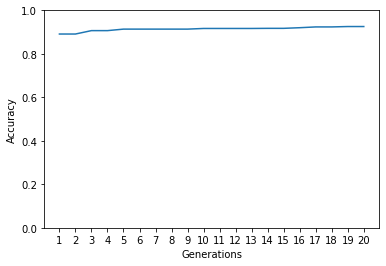

In [36]:
import matplotlib.pyplot as plt
plt.xlabel("Generations")
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.xticks(np.arange(1, epochs + 1))
plt.plot(np.arange(1,epochs + 1), fit_plt_aco)
plt.show()

In [37]:
nn = NeuralNetwork(layer_size, x_aco)
out = nn.forwardPropagation(x_test)
print(metrics.classification_report(np.round(out), y_test))

              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93       915
         1.0       0.91      0.95      0.93       893

    accuracy                           0.93      1808
   macro avg       0.93      0.93      0.93      1808
weighted avg       0.93      0.93      0.93      1808

